# xG model implementation

##### This code is borrowed heavily from https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython for the data treatment section

In [1]:
#The basics
import pandas as pd
import numpy as np
import json

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

##### Single run code

In [2]:
'''
#Decide which league to load
#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
with open('All_data.json') as f: #All_data is a dataset consisting of the fusion of all 7 competitions
    data = json.load(f)

train = pd.DataFrame(data)

shots=train[train['subEventName']=='Shot']

shots_model=pd.DataFrame(columns=['Goal','X','Y'])

#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1


shots_model.to_csv('shots.csv', index = False)
'''

"\n#Decide which league to load\n#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2\nwith open('All_data.json') as f: #All_data is a dataset consisting of the fusion of all 7 competitions\n    data = json.load(f)\n\ntrain = pd.DataFrame(data)\n\nshots=train[train['subEventName']=='Shot']\n\nshots_model=pd.DataFrame(columns=['Goal','X','Y'])\n\n#Go through the dataframe and calculate X, Y co-ordinates.\n#Distance from a line in the centre\n#Shot angle.\n#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events\nfor i,shot in shots.iterrows():\n    \n    header=0\n    for shottags in shot['tags']:\n        if shottags['id']==403:\n            header=1\n    #Only include non-headers        \n    if not(header):        \n        shots_model.at[i,'X']=100-shot['positions'][0]['x']\n        shots_model.at[i,'Y']=shot['positions'][0]['y']\n        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)\n    \n        #Distance in

In [3]:
data = pd.read_csv('shots.csv') #Load dataset with all shots from the 7 competitions

In [4]:
data

,Goal,X,Y,C,Distance,Angle
0,1,12,41,9.0,13.891814,0.474451
1,0,15,52,2.0,15.803560,0.453823
2,0,19,33,17.0,22.805811,0.280597
3,0,25,30,20.0,29.292704,0.223680
4,0,10,39,11.0,12.703248,0.479051
...,...,...,...,...,...,...
36086,1,8,53,3.0,8.623369,0.789654
36087,0,35,61,11.0,37.439084,0.191399
36088,0,19,33,17.0,22.805811,0.280597
36089,0,22,76,26.0,28.622019,0.206836


In [5]:
data.describe()

,Goal,X,Y,C,Distance,Angle
count,36091.000000,36091.000000,36091.000000,36091.000000,36091.000000,36091.000000
mean,0.100274,16.522596,49.166468,12.385941,19.943718,0.374042
std,0.300370,8.096451,14.598449,7.771339,8.113562,0.221278
min,0.000000,0.000000,0.000000,0.000000,0.650000,-0.000000
25%,0.000000,10.000000,37.000000,6.000000,13.895413,0.246902
50%,0.000000,15.000000,49.000000,12.000000,18.911174,0.304760
75%,0.000000,23.000000,61.000000,18.000000,25.933087,0.428496
max,1.000000,99.000000,100.000000,50.000000,103.952032,2.582829


In [6]:
x = data.drop(['Goal','X','Y','C'], axis=1)
y = data['Goal']

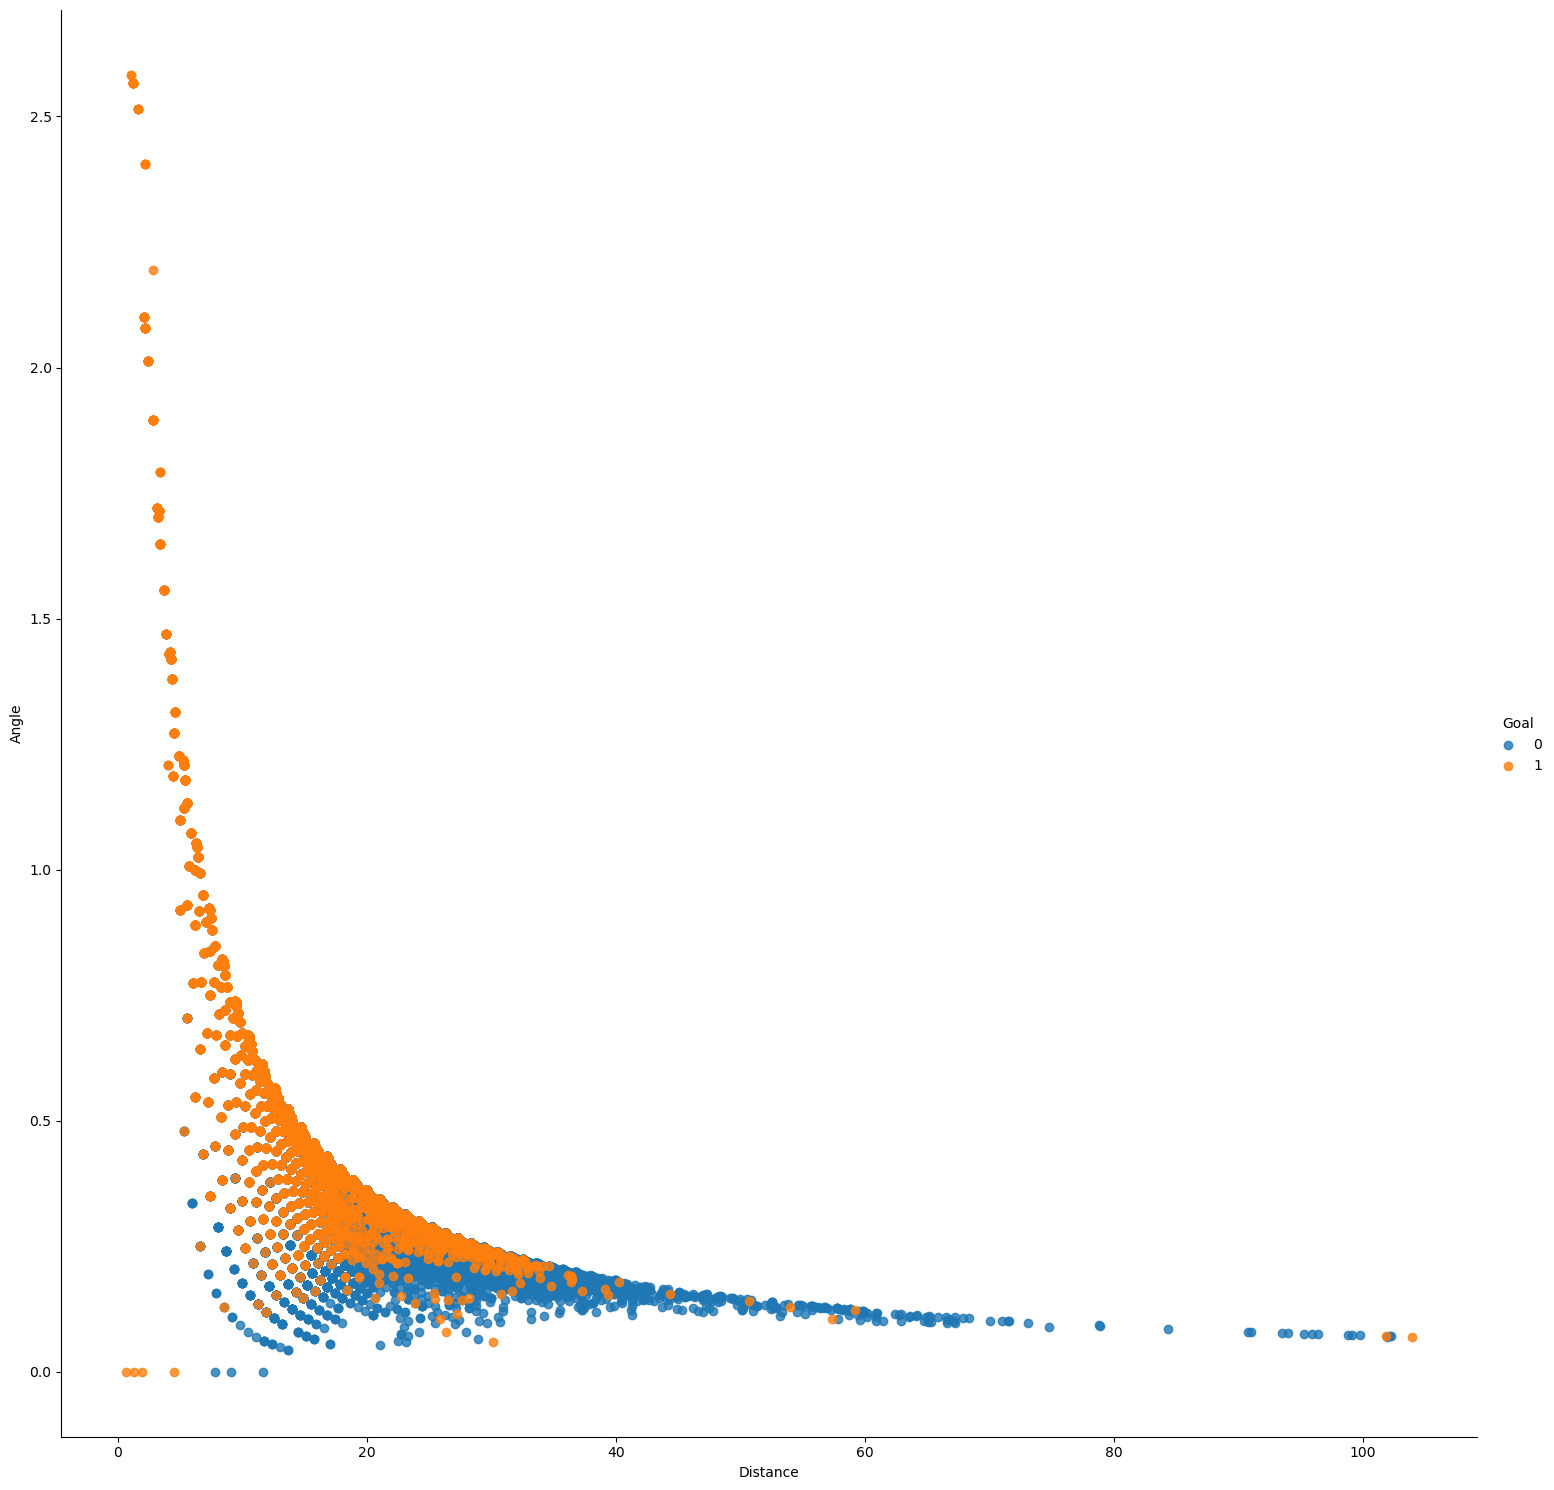

In [7]:
sns.lmplot(x= 'Distance', 
           y= 'Angle', 
           height=15,
           aspect=1,
           data=data, 
           fit_reg=False, 
           hue= 'Goal', 
           legend=True)

plt.xlabel("Distance")
plt.ylabel("Angle")
 
plt.show()

##### Data standardization (not used as it yielded worst results)

In [8]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#x = scaler.fit_transform(x)

In [9]:
# Train/test split
from sklearn.model_selection import train_test_split 
  
xtrain, xtest, ytrain, ytest = train_test_split( 
    x, y, test_size=0.25, random_state=123)

#### We implement oversampling and undersampling techniques (SMOTE, ADASYN and Cluster Centroids) until we have full class balance

In [10]:
oversample = SMOTE(random_state = 123)
xtrain_smote, ytrain_smote = oversample.fit_resample(xtrain, ytrain)

In [11]:
oversample = ADASYN(sampling_strategy = 0.5, random_state = 123)
xtrain_ada, ytrain_ada = oversample.fit_resample(xtrain, ytrain)

In [12]:
cc = ClusterCentroids(random_state = 123)
xtrain_res, ytrain_res = cc.fit_resample(xtrain, ytrain)

/home/macaco3001/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/macaco3001/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1362) found smaller than n_clusters (2728). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


### Logistic Regression models

In [13]:
from sklearn.linear_model import LogisticRegression 

classifier = LogisticRegression(random_state = 123) 
classifier.fit(xtrain, ytrain)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.9060179541172559
F1Score :  0.8758642047170241
AUC Score :  0.8021553596852826
PR-AUC Score: 0.36856109873314835
Best Threshold=0.096420
[[5640 2492]
 [ 207  684]]
Accuracy with custom threshold: 0.7008755402859359
F1Score with custom threshold: 0.7604580993268847
Coefficients: [[-0.10000641  1.71619144]]
Intercept: [-1.27302171]


In [14]:
classifier = LogisticRegression(random_state = 123) 
classifier.fit(xtrain_smote, ytrain_smote)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.7386678488307659
F1Score :  0.7883786410080711
AUC Score :  0.8020288003277019
PR-AUC Score: 0.36892041373191337
Best Threshold=0.469188
[[5663 2469]
 [ 207  684]]
Accuracy with custom threshold: 0.7034245816247368
F1Score with custom threshold: 0.7624132589576161
Coefficients: [[-0.08514875  2.3985075 ]]
Intercept: [0.36481587]


In [15]:
classifier = LogisticRegression(random_state = 123) 
classifier.fit(xtrain_ada, ytrain_ada)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.8490524215892719
F1Score :  0.8620326911723923
AUC Score :  0.8022089093371272
PR-AUC Score: 0.36869709258820166
Best Threshold=0.350396
[[5647 2485]
 [ 206  685]]
Accuracy with custom threshold: 0.7017621633603015
F1Score with custom threshold: 0.7611460153799742
Coefficients: [[-0.08736036  1.72760863]]
Intercept: [0.15069707]


In [16]:
classifier = LogisticRegression(random_state = 123) 
classifier.fit(xtrain_res, ytrain_res)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.6886844730134102
F1Score :  0.751137828551421
AUC Score :  0.8010766378326635
PR-AUC Score: 0.3664968098503296
Best Threshold=0.497038
[[5506 2626]
 [ 188  703]]
Accuracy with custom threshold: 0.6881303335919318
F1Score with custom threshold: 0.7507211217236727
Coefficients: [[-0.08765549  0.62362751]]
Intercept: [1.19322252]


### XGBOOST models

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier

In [23]:
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic', base_score = 0.1) #Base score of 0.1 accounts for class imbalance

# Fit the model to the training data
model.fit(xtrain, ytrain)
y_pred = model.predict(xtest)
y_score = model.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))

Accuracy :  0.9053529868114818
F1Score :  0.8759894724790943
AUC Score :  0.7865932511981044
PR-AUC Score: 0.3498617699741313
Best Threshold=0.116625
[[5941 2191]
 [ 253  638]]
Accuracy with custom threshold: 0.7291366507813366
F1Score with custom threshold: 0.7813711887196692


In [19]:
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# Fit the model to the training data
model.fit(xtrain_smote, ytrain_smote)
y_pred = model.predict(xtest)
y_score = model.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))

Accuracy :  0.7166130998559237
F1Score :  0.7721094210822455
AUC Score :  0.7823119703345971
PR-AUC Score: 0.34524958295061575
Best Threshold=0.554410
[[6149 1983]
 [ 273  618]]
Accuracy with custom threshold: 0.7499722930289261
F1Score with custom threshold: 0.7965021053912114


In [20]:
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# Fit the model to the training data
model.fit(xtrain_ada, ytrain_ada)
y_pred = model.predict(xtest)
y_score = model.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))

Accuracy :  0.8127008755402859
F1Score :  0.8380610088589147
AUC Score :  0.78060914661177
PR-AUC Score: 0.32925185138648916
Best Threshold=0.410670
[[6016 2116]
 [ 264  627]]
Accuracy with custom threshold: 0.7362296353762606
F1Score with custom threshold: 0.7864946703663069


In [21]:
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# Fit the model to the training data
model.fit(xtrain_res, ytrain_res)
y_pred = model.predict(xtest)
y_score = model.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))

Accuracy :  0.44464147179430347
F1Score :  0.5338882883036531
AUC Score :  0.7124149761262402
PR-AUC Score: 0.21762683986713516
Best Threshold=0.761672
[[5543 2589]
 [ 275  616]]
Accuracy with custom threshold: 0.6825889393771473
F1Score with custom threshold: 0.7459224872781307
